In [1]:
#Getting the helper functions and data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import *

import tensorflow_datasets as tfds
import tensorflow as tf


--2025-02-27 14:16:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-27 14:16:49 (94.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
tf.__version__

'2.18.0'

In [ ]:
 --version

Python 3.11.11


In [3]:
(train_data, test_data), data_info = tfds.load(name='food101',
                                               split=['train', 'validation'],
                                               as_supervised=True,
                                               shuffle_files=True,
                                               with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.LHTA1D_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.LHTA1D_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
data_info.features
class_names = data_info.features['label'].names
#Check out what is inside the data
one_sample = train_data.take(1)
for image, label in one_sample:
  print(image.shape)
  print(label)
  print(class_names[label.numpy()])

  #Check out the pixels:
  tf.reduce_min(image), tf.reduce_max(image)

(512, 512, 3)
tf.Tensor(21, shape=(), dtype=int64)
chocolate_cake


In [5]:
#Do the preprocessing
#Currreently the shape of images is different, they are also int64 instead of float32 + they are not batched, neither scaled

def preprocess_image(image, label, img_shape=224):
  """
      Ths is preprocessing function whith will convert the image to be a shape of (224,224) and of float32 format
  """

  image = tf.image.resize(image, [img_shape,img_shape])

  return tf.cast(image, tf.float32), label

In [6]:
#Batch and prepare datasts using map - we need to use preprocessing function, batch it and prefetch for faster processing
train_data = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
#Create the Callbacks for feature extraction
check_point_path='model/feature_extrc_food101.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(check_point_path,
                                                       monitor='val_accuracy',
                                                       save_best_only=True,
                                                       save_weights_only=True)

In [8]:
#Setup mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy='mixed_float16')

In [9]:
#create a model:

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape = input_shape, name='input_layer')
x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x = tf.keras.layers.Dense(len(class_names), name='dense_output_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmax_output')(x)
model = tf.keras.Model(inputs, outputs)


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
#Fitting the model, saming the checkpoint and history

history_feature_ext_effb0 = model.fit(train_data,
                                      epochs=3,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[model_checkpoint, create_tensorboard_callback(dir_name='logs_training',experiment_name='feature_extraction_effb4')])

Saving TensorBoard log files to: logs_training/feature_extraction_effb4/20250227-143115
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 243s 88ms/step - accuracy: 0.4782 - loss: 2.2882 - val_accuracy: 0.6894 - val_loss: 1.1467
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 179s 76ms/step - accuracy: 0.6683 - loss: 1.2830 - val_accuracy: 0.7188 - val_loss: 1.0295
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 167s 61ms/step - accuracy: 0.7055 - loss: 1.1312 - val_accuracy: 0.7267 - val_loss: 0.9922


In [ ]:
evaluate_model = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - accuracy: 0.7262 - loss: 1.0054


In [ ]:
#Saving the model to the collab
model.save('drive/MyDrive/Colab_Notebooks/feature_extraction_food101.keras')

In [ ]:
model_feature_extraction = tf.keras.models.load_model('drive/MyDrive/Colab_Notebooks/feature_extraction_food101.keras')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_output_layer (Dense)           │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_output (Activation)          │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling_layer True float32 <DTypePolicy "mixed_float16">
dense_output_layer True float32 <DTypePolicy "mixed_float16">
softmax_output True float32 <DTypePolicy "float32">


In [ ]:
evaluate_model

[0.9998810887336731, 0.7285148501396179]

In [ ]:
#Lets do fine-tuning now.
model_feature_extraction.trainable = True
#Lets unfreeze last 10 lasyers. If we unfreeze all we will overfit
for layer in model_feature_extraction.layers[:-10]:
  layer.trainable = False

for layer in model_feature_extraction.layers:
  print(layer, layer.trainable, layer.dtype)

<InputLayer name=input_layer, built=True> True float32
<Functional name=efficientnetb0, built=True> False float32
<GlobalAveragePooling2D name=global_average_pooling_layer, built=True> True float32
<Dense name=dense_output_layer, built=True> True float32
<Activation name=softmax_output, built=True> True float32


In [ ]:
#Callbacks implementation
#Early stopping see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop_call = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)
#Saving model during fine-tuning see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
save_model_best_call = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/Colab_Notebooks/fine_tuning_food101.keras',
                                                         monitor='val_loss',
                                                         save_best_only=True)


In [ ]:
#Implementing additional callback: see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
#Reduce learning rate when a metric has stopped improving
reducse_lr_call = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.2,
                                                       patience=2,
                                                       verbose=1,
                                                       min_lr=1e-7)

In [ ]:
model_feature_extraction.compile(loss='sparse_categorical_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(0.0001),
                                 metrics=['accuracy'])

history_fine_tune_foodBig = model_feature_extraction.fit(train_data,
                                                         epochs=103,
                                                         steps_per_epoch=len(train_data),
                                                         validation_data=test_data,
                                                         validation_steps=int(0.15*len(test_data)),
                                                         initial_epoch=history_feature_ext_effb0.epoch[-1],
                                                         callbacks=[early_stop_call, save_model_best_call, reducse_lr_call, create_tensorboard_callback(dir_name='logs_training',experiment_name='fine_tuning_food101')])

Saving TensorBoard log files to: logs_training/fine_tuning_food101/20250225-131836
Epoch 3/103
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 193s 71ms/step - accuracy: 0.7422 - loss: 0.9938 - val_accuracy: 0.7317 - val_loss: 0.9594 - learning_rate: 1.0000e-04
Epoch 4/103
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - accuracy: 0.7495 - loss: 0.9733 - val_accuracy: 0.7360 - val_loss: 0.9538 - learning_rate: 1.0000e-04
Epoch 5/103
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 83ms/step - accuracy: 0.7490 - loss: 0.9637 - val_accuracy: 0.7349 - val_loss: 0.9566 - learning_rate: 1.0000e-04
Epoch 6/103
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7541 - loss: 0.9509
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 151s 64ms/step - accuracy: 0.7541 - loss: 0.9509 - val_accuracy: 0.7373 - val_loss: 0.9542 - learning_rate: 1.0000e-04
Epoch 7/103
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 89ms/step - accuracy: 0.7597 - loss: 0.9305 - val_accuracy: 0.7381

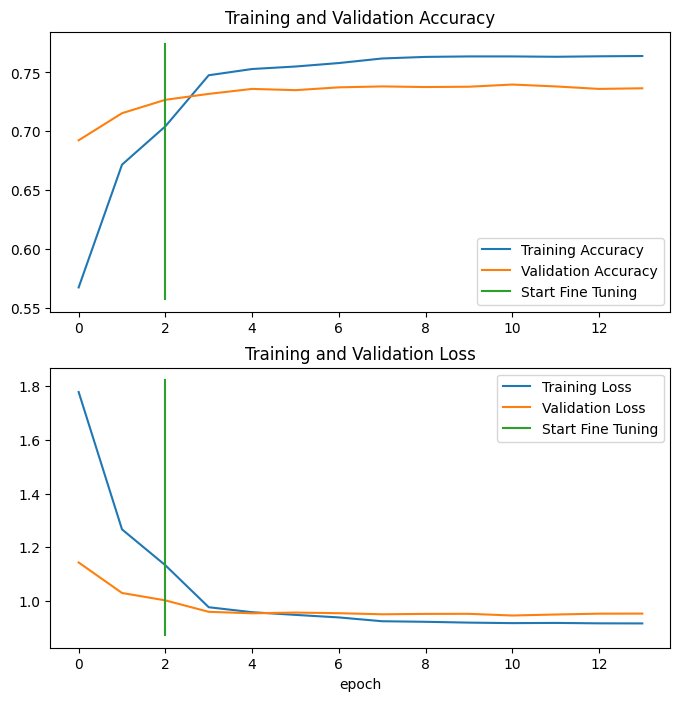

In [ ]:
compare_historys(original_history=history_feature_ext_effb0,
                 new_history=history_fine_tune_foodBig,
                 initial_epochs=3)

In [ ]:
fined_tuned_model = model_feature_extraction.evaluate(test_data)


790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.7367 - loss: 0.9553


In [ ]:
loaded_ft_model = tf.keras.models.load_model('drive/MyDrive/Colab_Notebooks/fine_tuning_food101.keras')

In [ ]:
test_loss, accuracy = loaded_ft_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step - accuracy: 0.7370 - loss: 0.9570
